### Introduction

This project will be demonstrating how to use and retrain pre-trained Faster R-CNN model to detect guns in images at a significant accuracy. Kaggle dataset of 333 gun images in different contexts will be used to retrain the algorithm

<img src='faster r-cnn.jfif' >

### Importing Libraries

In [23]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading sample images with annotations

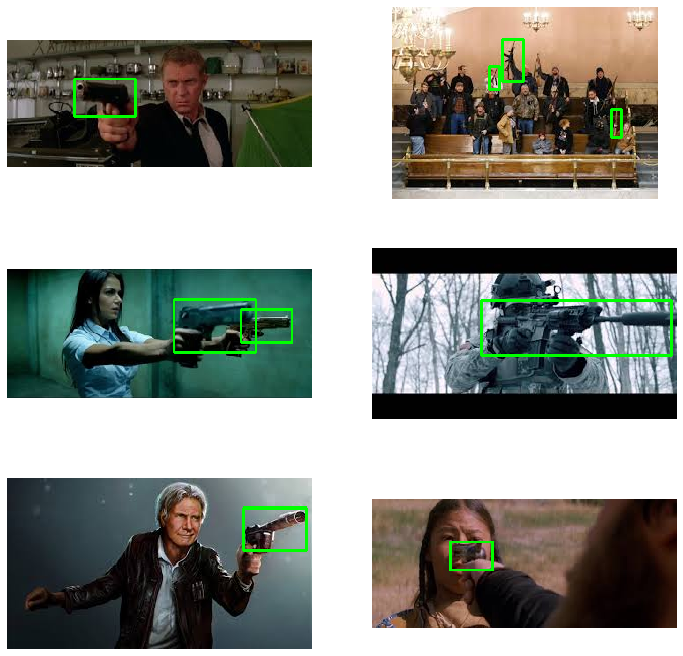

In [20]:
plt.figure(figsize=(12, 12))
for image_id in range(1, 7):
    plt.subplot(3, 2, image_id)
    img = cv2.imread("Images/"+str(image_id)+".jpeg")
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    with open("Labels/"+str(image_id)+".txt", "r") as f:
        label = f.read().split('\n')
        for rect in label[1:-1]:
            [p0, p1, p2, p3] = [int(i) for i in rect.split()]
            
            img = cv2.rectangle(img=img, pt1=(p0, p1), pt2=(p2, p3), color=(0, 255, 0), thickness=2)
    plt.axis('off')
    plt.imshow(img)

### Loading data into memory

In [21]:
image_path_list = glob.glob("Images/*.jpeg")

In [24]:
def read_images_and_labels(image_path_list):
    images_dict = {}
    for i, image_path in enumerate(image_path_list):
        image = cv2.imread(image_path)
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
        (h0, w0,_) = image.shape
        (h1, w1,_) = image.shape
        image=image/255.0
        image_id = os.path.basename(image_path)[:-5]
        annotations = []
        with open("Labels/"+str(image_id)+".txt", "r") as f:
            label = f.read().split('\n')
            for rect in label[1:-1]:
                [p0, p1, p2, p3] = [int(i) for i in rect.split()]
                annotations.append([p0, p1, p2, p3])
    
        # add to our images array
        images_dict[image_id] = {'image': image, 'annotations': annotations}
    return images_dict

In [25]:
images = read_images_and_labels(image_path_list)

In [26]:
images['1']['annotations'][0]

[76, 45, 146, 87]

### Test newly packed images and annotations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


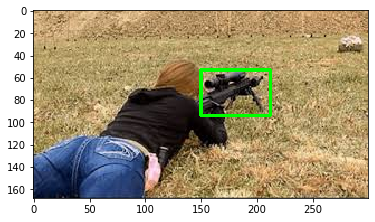

Image size =  (168, 300, 3)


In [28]:
img = cv2.rectangle(img=images['27']['image'], pt1=(images['27']['annotations'][0][0], images['27']['annotations'][0][1]), \
                                            pt2=(images['27']['annotations'][0][2], images['27']['annotations'][0][3]), \
                    color=(0, 255, 0),thickness=2)
plt.imshow(img)
plt.show()
print("Image size = ", img.shape)

### Shuffling dataset to train, validation and test images

In [29]:
len(images)

333

In [30]:
def train_val_test_split(images_dict):
    # 70% training, 20% validation, 10% testing
    train_limit, val_limit = int(0.7*len(images)), int(0.9*len(images))

    np.random.seed = 21
    shuffled_inds = np.random.permutation(np.arange(len(images)))
    train_inds, val_inds, test_inds=shuffled_inds[:train_limit], shuffled_inds[train_limit:val_limit],shuffled_inds[val_limit:]

    train_images, val_images, test_images = {str(i):images[str(i)] for i in train_inds+1}, \
                                            {str(j):images[str(j)] for j in val_inds+1}, \
                                            {str(k):images[str(k)] for k in test_inds+1}
    return train_images, val_images, test_images

### Write Annotations to COCO JSON Format

In [31]:
def to_COCO_json(images_dict):
    main = {}
    main['info'] = {'description':'COCO Format Annots', 'url':'None', 'version':'1.0', 'year':2019, 'contributor':'None', 
                    'date_created':'11/20/2019'}
    main['licenses'] = [{'url':'None', 'id':1, 'name':'None'}]
    main['categories'] = [{'supercategory':'weapon', 'id':1, 'name':'gun'}]
    main['images'] = []
    main['annotations'] = []
    annot_id = 0
    for image in images_dict:
        main['images'].append({'license':1,
                               'file_name':str(image)+".jpeg",
                               'coco_url':'None',
                               'height':images[image]['image'].shape[0], 
                               'width':images[image]['image'].shape[1], 
                               'date_captured':'N/A', 'id':int(image)})
        for annot in images[image]['annotations']:
            main['annotations'].append({'bbox':[annot[0], annot[1], annot[2]-annot[0], annot[3]-annot[1]], 
                                        'image_id':int(image), 'category_id':1, 'id':annot_id, 'iscrowd':0,
                                        'area':(annot[3]-annot[1])*(annot[2]-annot[0]), 'segmentation':[]})
            annot_id+=1
    return json.dumps(main)

In [32]:
train_images, val_images, test_images = train_val_test_split(images)

In [33]:
with open('Annotations/coco_train_annotations.json', 'w') as f:
    f.write(to_COCO_json(train_images))
with open('Annotations/coco_val_annotations.json', 'w') as f:
    f.write(to_COCO_json(val_images))
with open('Annotations/coco_test_annotations.json', 'w') as f:
    f.write(to_COCO_json(test_images))

### Converting COCO annotations to TF records

In [ ]:
!python C:/Users/ali95/models/research/object_detection/dataset_tools/create_coco_tf_record.py --train_image_dir="C:\Users\ali95\Desktop\guns-object-detection\Images" --val_image_dir="C:\Users\ali95\Desktop\guns-object-detection\Images" --test_image_dir="C:\Users\ali95\Desktop\guns-object-detection\Images" --train_annotations_file="Annotations/coco_train_annotations.json" --val_annotations_file="Annotations/coco_val_annotations.json" --testdev_annotations_file="Annotations/coco_test_annotations.json" --output_dir="Outputs" 

### Transfer Learning Using Faster R-CNN 

In [1]:
!python C:/Users/ali95/models/research/object_detection/legacy/train.py --train_dir=CP --pipeline_config_path=C:/Users/ali95/Desktop/guns-object-detection/faster_rcnn_resnet101_coco_2018_01_28/pipeline.config

Traceback (most recent call last):
  File "C:/Users/ali95/models/research/object_detection/legacy/train.py", line 47, in <module>
    import tensorflow as tf
ModuleNotFoundError: No module named 'tensorflow'


<img src='training.JPG' >

In [ ]:
! python C:/Users/ali95/models/research/object_detection/export_inference_graph.py --input_type=image_tensor --pipeline_config_path=C:/Users/ali95/Desktop/guns-object-detection/faster_rcnn_resnet101_coco_2018_01_28/pipeline.config --trained_checkpoint_prefix=C:/Users/ali95/Desktop/guns-object-detection/CP/model.ckpt-1691 --output_directory=C:/Users/ali95/Desktop/guns-object-detection/IG

### Model Evaluation

In [13]:
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'C:/Users/ali95/Desktop/guns-object-detection/IG/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'C:/Users/ali95/Desktop/guns-object-detection/label.pbtxt'

#Number of classes
NUM_CLASSES = 1

In [14]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [15]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [16]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [17]:
PATH_TO_TEST_IMAGES_DIR = 'C:/Users/ali95/Desktop/guns-object-detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [18]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

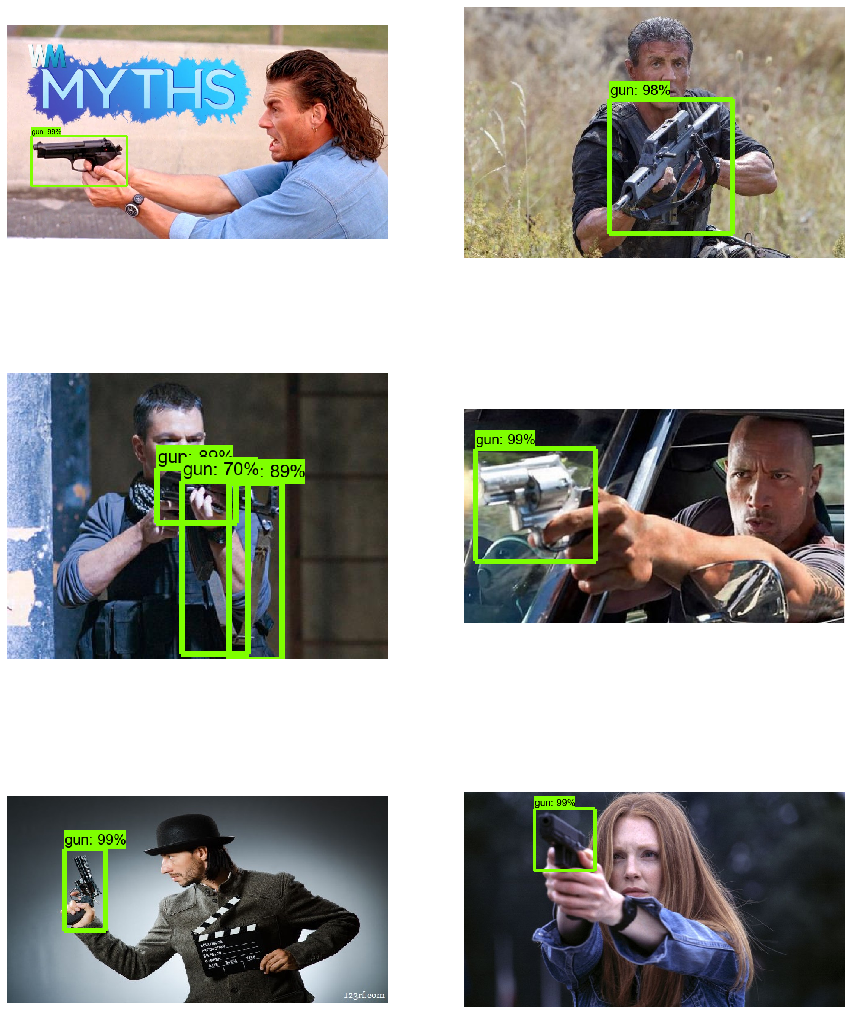

In [19]:
fig = plt.figure(figsize=(15, 20))
for i, image_path in enumerate(TEST_IMAGE_PATHS):
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)

  ax = fig.add_subplot(3, 2, i+1)
  ax.axis('off')
  ax.imshow(image_np)